In [1]:
import pandas as pd
import numpy as np 
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

train = pd.read_csv('/Users/emilyvincett/Downloads/home-data-for-ml-course/train.csv')
test = pd.read_csv('/Users/emilyvincett/Downloads/home-data-for-ml-course/test.csv')


In [2]:
# Split the datasets into nominal categorical, ordinal categorical, discrete, continuous 

nominal_variables = ['MSSubClass','MSZoning','Street','Alley','LotShape','LandContour','Utilities','LotConfig',
                    'LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','RoofStyle',
                    'RoofMatl','Exterior1st','Exterior2nd','MasVnrType','Foundation','Heating','CentralAir',
                     'GarageType','MiscFeature','SaleType', 'SaleCondition']

ordinal_variables = ['OverallQual','OverallCond','ExterQual','ExterCond','BsmtCond','BsmtExposure','BsmtFinType1',
                    'BsmtFinType2','HeatingQC','Electrical','KitchenQual','Functional','FireplaceQu','GarageFinish',
                    'GarageQual','GarageCond','PavedDrive','PoolQC','Fence','LotShape','Utilities','LandSlope']

continuous_variables = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF',
                       '2ndFlrSF','LowQualFinSF','GrLivArea','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch',
                       'ScreenPorch','PoolArea','MiscVal']

discrete_variables = ['YearBuilt','YearRemodAdd','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd',
                     'Fireplaces','GarageYrBlt','GarageCars','MoSold','YrSold']


print('The number of categorical columns is {}\nThe number of numerical columns is {}'
      .format(train.select_dtypes(include='object').shape[1], train.select_dtypes(exclude='object').shape[1]))
print('The number of nominal categorical variables is {}\nThe number of ordinal variable {}\nThe number of Continuous Variables is {}\nThe number of Discrete Variables {}'
      .format(len(nominal_variables),len(ordinal_variables),len(continuous_variables),len(discrete_variables)))
print('Total is {}'.format((len(nominal_variables)+len(ordinal_variables)+len(continuous_variables)+len(discrete_variables))))

The number of categorical columns is 43
The number of numerical columns is 38
The number of nominal categorical variables is 26
The number of ordinal variable 22
The number of Continuous Variables is 19
The number of Discrete Variables 14
Total is 81


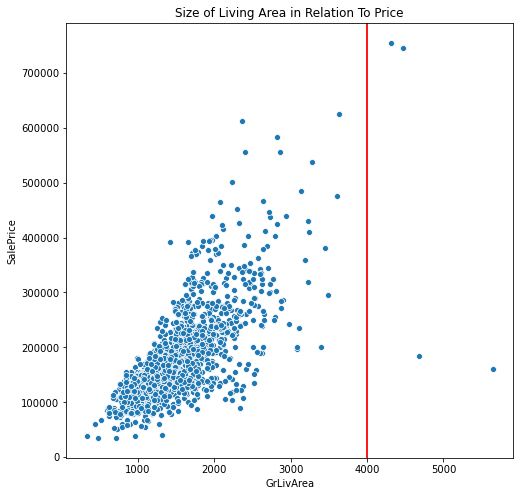

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,8))
sns.scatterplot(train['GrLivArea'],train['SalePrice'])
plt.axvline(x=4000, c='r',linewidth=1.8)
plt.title('Size of Living Area in Relation To Price')
train = train.drop(train[train['GrLivArea']>4000].index)
plt.show()

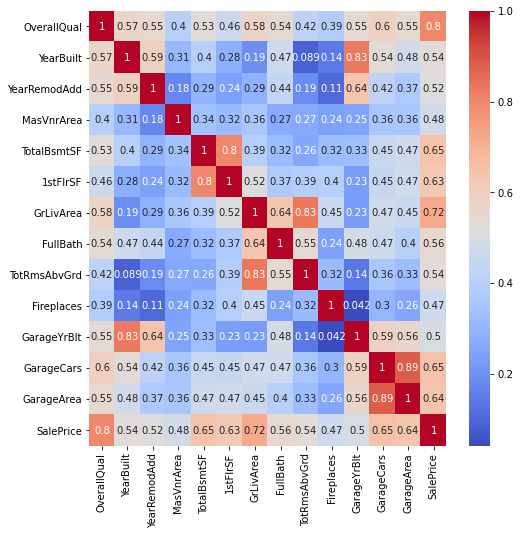

In [4]:
# The correlation function will automatically choose only numerical columns, so no need to segregate
correlation = train.corr()
top_correlation = correlation.index[abs(correlation['SalePrice'])>0.4]
plt.figure(figsize=(8,8))
g = sns.heatmap(train[top_correlation].corr(), annot=True ,cmap='coolwarm')

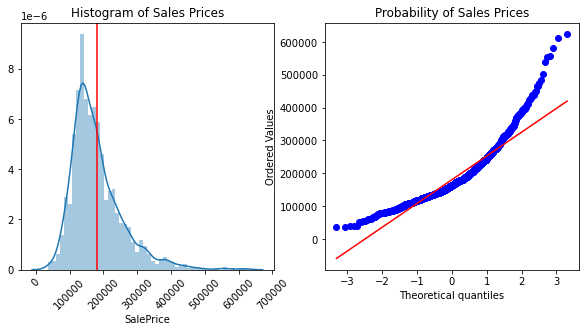

In [5]:
from scipy import stats

#  Test the target variable for normality 
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
sns.distplot(train['SalePrice'],bins=50)
plt.axvline(train['SalePrice'].mean(), c='r')
plt.title('Histogram of Sales Prices')
plt.xticks(rotation=45)


plt.subplot(2,2,2)
stats.probplot(train['SalePrice'],plot=plt)
plt.title('Probability of Sales Prices')
plt.show()

In [6]:
print('The skew of the target variable is %f and as such it needs to be transformed' %(train['SalePrice'].skew()))

The skew of the target variable is 1.565959 and as such it needs to be transformed


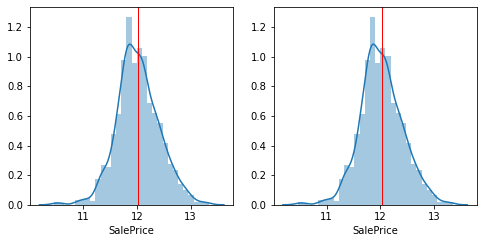

Log Normal skew is 0.065449, BoxCox skew is 0.065450


In [7]:
from scipy.special import boxcox

train_2 = train.copy()
train_2['SalePrice'] = np.log(train_2['SalePrice'])
a = train_2['SalePrice'].skew()


# The smaller the lambda the better the skew towards normality
train_3 = train.copy()
train_3['SalePrice'] = boxcox(train_3['SalePrice'], 0.000001)
b = train_3['SalePrice'].skew()

plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
sns.distplot(train_2['SalePrice'],bins=30)
plt.axvline(x=train_2['SalePrice'].mean(),linewidth=1, c='r')
plt.subplot(2,2,2)
sns.distplot(train_3['SalePrice'],bins=30)
plt.axvline(x=train_3['SalePrice'].mean(), linewidth=1, c='r')
plt.show()



print('Log Normal skew is %f, BoxCox skew is %f'%(a,b))

In [8]:
# Transform the target variable using Log Normal Skew
target = np.log(train.iloc[:,-1])

In [9]:
# Train columns with null values 

nulls = train.isnull().sum()>0
null_columns = nulls[nulls.values==True].index
print('These are the columns with null values to be addressed {}'.format(null_columns))

These are the columns with null values to be addressed Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')


In [10]:
#percentages = {}
#for x in null_columns:
 #   percentages[x] = train[x].isnull().sum()/len(train[x])*100 

In [11]:
train['LotFrontage'].fillna(train.groupby(['Neighborhood'])['LotFrontage'].transform('median'),inplace=True)
train['Alley'].fillna(method='bfill',inplace=True)
train['Alley'].fillna(method='pad',inplace=True)
train['MasVnrType'].fillna(train.groupby(['Neighborhood','BldgType','YearRemodAdd'])['MasVnrType'].transform('ffill'),inplace=True)
train['MasVnrArea'].fillna(train.groupby(['MasVnrType'])['MasVnrArea'].transform('median'),inplace=True)
train['BsmtQual'].fillna(value = train.groupby(['Neighborhood','OverallQual','BldgType'])['BsmtQual'].transform('bfill'),inplace=True)
train['BsmtQual'].fillna(method='pad',inplace=True)
train['BsmtCond'].fillna(train.groupby(['BsmtQual'])['BsmtCond'].transform('bfill'),inplace=True)
train['BsmtCond'].fillna(method='pad',inplace=True)
train['BsmtExposure'].fillna(train.groupby(['BldgType'])['BsmtExposure'].transform('ffill'),inplace=True)
train['BsmtFinType1'].fillna(train.groupby(['Neighborhood','YearRemodAdd'])['BsmtFinType1'].transform('ffill'),inplace=True)
train['BsmtFinType1'].fillna(method='pad',inplace=True)
train['BsmtFinType2'].fillna(train.groupby(['Neighborhood','YearRemodAdd'])['BsmtFinType2'].transform('ffill'),inplace=True)
train['BsmtFinType2'].fillna(method='pad',inplace=True)
train['Electrical'].fillna(method='pad',inplace=True)
train['FireplaceQu'].fillna(train.groupby(['OverallQual'])['FireplaceQu'].transform('bfill'),inplace=True)
train['GarageYrBlt'].fillna(train.groupby(['YearBuilt'])['GarageYrBlt'].transform('median'),inplace=True)
train['GarageYrBlt'].fillna(method='pad',inplace=True)
train['GarageType'].fillna(train.groupby(['BldgType','GarageYrBlt'])['GarageType'].transform('bfill'),inplace=True)
train['GarageType'].fillna(method='pad',inplace=True)
train['GarageFinish'].fillna(train.groupby(['GarageYrBlt'])['GarageFinish'].transform('ffill'),inplace=True)
train['GarageFinish'].fillna(method='pad',inplace=True)
train['GarageQual'].fillna(train.groupby(['GarageYrBlt'])['GarageQual'].transform('ffill'),inplace=True)
train['GarageQual'].fillna(method='pad',inplace=True)
train['GarageCond'].fillna(train.groupby(['Neighborhood'])['GarageCond'].transform('ffill'),inplace=True)
train['Fence'].fillna(train.groupby(['Neighborhood'])['Fence'].transform('ffill'),inplace=True)
train['Fence'].fillna(method='pad',inplace=True)
train['MiscFeature'].fillna(train.groupby(['Neighborhood','BldgType','OverallQual'])['MiscFeature'].transform('ffill'),inplace=True)


In [12]:
# Test columns with null values 
null_col = test.isnull().sum()>0
print('These are the null columns {}'.format(null_col[null_col.values==True].index))

These are the null columns Index(['MSZoning', 'LotFrontage', 'Alley', 'Utilities', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath',
       'BsmtHalfBath', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea',
       'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType'],
      dtype='object')


In [13]:
#percentages={}

#for x in null_col[null_col.values==True].index:
#    percentages[x] = test[x].isnull().sum()/len(test[x])*100    

In [14]:
test['LotFrontage'].fillna(test.groupby(['Neighborhood'])['LotFrontage'].transform('median'),inplace=True)
test['Alley'].fillna(method='bfill',inplace=True)
test['Alley'].fillna(method='pad',inplace=True)
test['MasVnrType'].fillna(test.groupby(['Neighborhood','BldgType','YearBuilt'])['MasVnrType'].transform('ffill'),inplace=True)
test['MasVnrArea'].fillna(test.groupby(['MasVnrType'])['MasVnrArea'].transform('median'),inplace=True)
test['BsmtQual'].fillna(value = test.groupby(['Neighborhood','OverallQual','BldgType'])['BsmtQual'].transform('ffill'),inplace=True)
test['BsmtQual'].fillna(method='pad',inplace=True)
test['BsmtCond'].fillna(test.groupby(['BsmtQual'])['BsmtCond'].transform('ffill'),inplace=True)
test['BsmtCond'].fillna(method='pad',inplace=True)
test['BsmtExposure'].fillna(test.groupby(['BldgType'])['BsmtExposure'].transform('ffill'),inplace=True)
test['BsmtFinType1'].fillna(test.groupby(['Neighborhood','YearRemodAdd'])['BsmtFinType1'].transform('ffill'),inplace=True)
test['BsmtFinType1'].fillna(method='pad',inplace=True)
test['BsmtFinType2'].fillna(test.groupby(['Neighborhood','YearRemodAdd'])['BsmtFinType2'].transform('ffill'),inplace=True)
test['BsmtFinType2'].fillna(method='pad',inplace=True)
test['Electrical'].fillna(method='pad',inplace=True)
test['FireplaceQu'].fillna(test.groupby(['MasVnrType'])['FireplaceQu'].transform('bfill'),inplace=True)
test['GarageYrBlt'].fillna(test.groupby(['YearBuilt'])['GarageYrBlt'].transform('median'),inplace=True)
test['GarageYrBlt'].fillna(method='pad',inplace=True)
test['GarageType'].fillna(test.groupby(['BldgType','GarageYrBlt'])['GarageType'].transform('bfill'),inplace=True)
test['GarageType'].fillna(method='pad',inplace=True)
test['GarageFinish'].fillna(test.groupby(['GarageYrBlt'])['GarageFinish'].transform('ffill'),inplace=True)
test['GarageFinish'].fillna(method='pad',inplace=True)
test['GarageQual'].fillna(test.groupby(['GarageYrBlt'])['GarageQual'].transform('ffill'),inplace=True)
test['GarageQual'].fillna(method='pad',inplace=True)
test['GarageCond'].fillna(test.groupby(['Neighborhood'])['GarageCond'].transform('ffill'),inplace=True)
test['Fence'].fillna(test.groupby(['Neighborhood'])['Fence'].transform('ffill'),inplace=True)
test['Fence'].fillna(method='pad',inplace=True)
test['MSZoning'].fillna(test.groupby(['Neighborhood'])['MSZoning'].transform('ffill'),inplace=True)
test['Alley'].fillna(test.groupby(['Neighborhood'])['Alley'].transform('bfill'),inplace=True)
test['Utilities'].fillna(test.groupby(['YearRemodAdd'])['Utilities'].transform('ffill'),inplace=True)
test['Exterior1st'].fillna(test.groupby(['MasVnrType'])['Exterior1st'].transform('ffill'),inplace=True)
test['Exterior2nd'].fillna(test.groupby(['MasVnrType'])['Exterior2nd'].transform('ffill'),inplace=True)
test['BsmtFinSF1'].fillna(test.groupby(['YearRemodAdd'])['BsmtFinSF1'].transform('ffill'),inplace=True)
test['BsmtFinSF2'].fillna(test.groupby(['YearRemodAdd'])['BsmtFinSF2'].transform('ffill'),inplace=True)
test['BsmtUnfSF'].fillna(test.groupby(['YearRemodAdd'])['BsmtUnfSF'].transform('ffill'),inplace=True)
test['TotalBsmtSF'].fillna(test.groupby(['BldgType','YearRemodAdd'])['BsmtUnfSF'].transform('ffill'),inplace=True)
test['Functional'].fillna(test.groupby(['BldgType','TotRmsAbvGrd'])['Functional'].transform('ffill'),inplace=True)
test['BsmtFullBath'].fillna(test.groupby(['BldgType','TotRmsAbvGrd'])['BsmtFullBath'].transform('ffill'),inplace=True)
test['BsmtHalfBath'].fillna(test.groupby(['BldgType','TotRmsAbvGrd'])['BsmtHalfBath'].transform('ffill'),inplace=True)
test['KitchenQual'].fillna(test.groupby(['OverallQual','KitchenAbvGr'])['KitchenQual'].transform('ffill'),inplace=True)
test['FireplaceQu'].fillna(test.groupby(['OverallQual','TotRmsAbvGrd','KitchenAbvGr'])['FireplaceQu'].transform('ffill'),inplace=True)
test['GarageCars'].fillna(test.groupby(['Neighborhood','BldgType'])['GarageCars'].transform('ffill'),inplace=True)
test['SaleType'].fillna(test.groupby(['SaleCondition','Neighborhood'])['SaleType'].transform('ffill'),inplace=True)
test['GarageArea'].fillna(test.groupby(['GarageCars'])['GarageArea'].transform('ffill'),inplace=True)


In [15]:
combo = train.append(test)

In [16]:
# Reduce cardinality of the feature set

combo['Lot'] = combo['LotArea']*combo['LotFrontage']
combo['TotalHouseSF'] = combo['TotalBsmtSF']+combo['1stFlrSF']+combo['2ndFlrSF']
combo['PorchSF'] = combo['OpenPorchSF']+combo['EnclosedPorch']+combo['3SsnPorch']+combo['ScreenPorch']
combo['DateSold'] = combo['MoSold'].astype(str)+'-'+combo['YrSold'].astype(str)
combo['TotBaths'] = combo['BsmtFullBath']+combo['BsmtHalfBath']+combo['FullBath']+combo['HalfBath']
combo['HasFireplace'] = np.where(combo['Fireplaces']>0,1,0)
combo['HasGarage'] = np.where(combo['GarageArea']>0,1,0)
combo['HasBsmt'] = np.where(combo['TotalBsmtSF']>0,1,0)
combo['HasWoodDeck'] = np.where(combo['WoodDeckSF']>0,1,0)
combo['HasPool'] = np.where(combo['PoolArea']>0,1,0)

cols_to_drop = ['LotArea','LotFrontage','TotalBsmtSF','1stFlrSF','2ndFlrSF',
               'OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch',
               'MoSold','YrSold','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath',
                'GarageCars','SalePrice']
combo.drop(cols_to_drop,axis=1,inplace=True)

In [17]:
from sklearn.preprocessing import PowerTransformer, MinMaxScaler,QuantileTransformer


num_features = combo.select_dtypes(exclude='object')
num_features = num_features.apply(lambda x: x.skew()).sort_values(ascending=False)
num_features = num_features.to_frame()
num_features.rename({0:'Skew'},axis=1,inplace=True)
num_features.drop(['HasGarage','HasBsmt'],axis=0,inplace=True)
skew = num_features[(num_features['Skew']>0.5)|(num_features['Skew']<-0.5)]
skew



,Skew
MiscVal,21.943440
PoolArea,18.711459
Lot,18.656553
HasPool,16.194866
LowQualFinSF,12.086535
KitchenAbvGr,4.301059
BsmtFinSF2,4.143709
MasVnrArea,2.589649
PorchSF,2.244587
WoodDeckSF,1.849236


In [18]:
#Scale = [MiscVal,PoolArea,LowQualFinSF,KitchenAbvGr,BsmtFinSF2]
#Transform = [MasVnrArea,PorchSF,WoodDeckSF,MSSubClass,GrLivArea,BsmtFinSF1,TotalHouseSF,
# BsmtUnfSF,TotRmsAbvGrd,Fireplaces,OverallCond,YearBuilt]

transform = ['MasVnrArea','PorchSF','WoodDeckSF','MSSubClass','GrLivArea','TotalHouseSF',
            'BsmtUnfSF','TotRmsAbvGrd','Fireplaces','OverallCond','YearBuilt']

scaled = ['MiscVal','PoolArea','LowQualFinSF','KitchenAbvGr']

pt = PowerTransformer(method='yeo-johnson',standardize=True)
scaler = MinMaxScaler()

_ = pt.fit_transform(combo[transform])
_ = pd.DataFrame(_,columns=transform)

qt = QuantileTransformer()
__ = pd.DataFrame(qt.fit_transform(combo[scaled]),columns=scaled)

cols_to_drop = ['MasVnrArea_x','PorchSF_x','WoodDeckSF_x','MSSubClass_x','GrLivArea_x','TotalHouseSF_x',
            'BsmtUnfSF_x','TotRmsAbvGrd_x','Fireplaces_x','OverallCond_x','YearBuilt_x',
                'MiscVal_x','PoolArea_x','LowQualFinSF_x','KitchenAbvGr_x','PoolArea_y']

combo_2 = combo.merge(_,left_on=combo.index, right_on=_.index).sort_values('Id',ascending=True).reset_index(drop=True).drop('key_0',axis=1)
combo_2 = combo_2.merge(__,left_on=combo_2.index,right_on=__.index)
combo_2 = combo_2.drop(cols_to_drop,axis=1)
combo_2 = combo_2.drop('key_0',axis=1)
combo_2.select_dtypes(include=float)

cols_to_rename = {'MasVnrArea_y':'MasVnrArea','PorchSF_y':'PorchSF','WoodDeckSF_y':'WoodSeckSF',
                  'MSSubClass_y':'MSSubClass','GrLivArea_y':'GrLivArea','TotalHouseSF_y':'TotalHouseSF',
                 'BsmtUnfSF_y':'BsmtUnfSF','TotRmsAbvGrd_y':'TotRmsAbvGrd','Fireplaces_y':'Fireplaces',
                 'OverallCond_y':'OverallCond','YearBuilt_y':'YearBuilt','MiscVal_y':'MiscVal',
                'LowQualFinSF_y':'LowQualFinSF','KitchenAbvGr_y':'KitchenAbvGr'}
combo_2.rename(cols_to_rename, axis=1,inplace=True)

In [19]:
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder,OneHotEncoder
ordinal_variables_2 = ['OverallQual','ExterQual','ExterCond','BsmtCond','BsmtExposure','BsmtFinType1',
                    'BsmtFinType2','HeatingQC','Electrical','KitchenQual','Functional','FireplaceQu','GarageFinish',
                    'GarageQual','GarageCond','PavedDrive','Fence','LotShape','Utilities','LandSlope','DateSold']

for x in combo_2[ordinal_variables_2]:
    combo_2[x] = LabelEncoder().fit_transform(combo_2[x])


nominal_variables_2 = ['MSSubClass','MSZoning','Street','Alley','LotShape','LandContour','Utilities','LotConfig',
                    'LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','RoofStyle',
                    'RoofMatl','Exterior1st','Exterior2nd','MasVnrType','Foundation','Heating','CentralAir',
                     'GarageType','SaleType', 'SaleCondition','BsmtQual']

encoded_features = []

for y in nominal_variables_2: 
    encoded_feat = OneHotEncoder().fit_transform(combo_2[y].values.reshape(-1,1)).toarray()
    
    n = combo_2[y].nunique()
    cols = ['{}_{}'.format(y,n) for n in range(1, n+1)]
    encoded_df = pd.DataFrame(encoded_feat,columns=cols)
    encoded_df.index = combo_2.index
    encoded_features.append(encoded_df)

combo_3 = pd.concat([combo_2, *encoded_features],axis=1).drop(nominal_variables_2,axis=1)
combo_3['BsmtQual_1']
combo_3.drop(['PoolQC','MiscFeature'],axis=1,inplace=True)

In [20]:
train_1 = combo_3.iloc[:1456]
test_1 = combo_3.iloc[1456:]

In [53]:
from sklearn.model_selection import train_test_split,GridSearchCV, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

X_train,X_test,y_train,y_test = train_test_split(train_1,target,test_size=0.33,random_state=0)


In [46]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ridge_regression 
rf = RandomForestRegressor(random_state=0)
gb = GradientBoostingRegressor(random_state=0)

kf = KFold(n_splits=10)

#grid_values = {'n_estimators':[100,3000],
              # 'max_depth':[5,20,50],
              # 'max_features':['auto','sqrt','log2']
             # }

#grid_rf_mse = GridSearchCV(rf, param_grid=grid_values,scoring='neg_mean_squared_error',n_jobs=-1, cv=kf)
results = rf.fit(X_train,y_train)
predictions = rf.predict(X_test)
score = rf.score(X_train,y_train)
score


0.9763127687994323

In [49]:
test_predictions = rf.predict(test_1)
test_predictions = list(test_predictions)
test_predictions = np.expm1(test_predictions)
test_set = pd.DataFrame(list(zip(test_1['Id'],test_predictions)))
test_set.rename({0:'Id',1:'SalePrice'},axis=1,inplace=True)
test_set

filename = 'Engineered House Prices1.csv'
test_set.to_csv(filename,index=False)
print('Saving File ' + filename)

Saving File Engineered House Prices1.csv
